In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tushare as ts

tf.random.set_seed(8)

pro = ts.pro_api()
pro = ts.pro_api('107616fccaaf92567ab2299cf5b6ce3b5044922d11045bebe6664811')

df = ts.get_k_data('600887', start='2020-12-01', end='2021-12-31')
# df = pd.concat([data.DataReader(t, source, start, end) for t in tickers]).reset_index()
dates = df["date"]
df



本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


/opt/anaconda3/lib/python3.9/site-packages/tushare/stock/trading.py:706: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(_get_k_data(url, dataflag,


,date,open,close,high,low,volume,code
220,2020-12-01,36.34,36.77,36.94,36.21,359018.0,600887
221,2020-12-02,37.10,36.76,37.12,36.39,322541.0,600887
222,2020-12-03,36.87,37.16,37.32,36.64,339247.0,600887
223,2020-12-04,37.45,38.01,38.10,37.21,529296.0,600887
224,2020-12-07,38.22,38.40,38.82,38.00,693086.0,600887
...,...,...,...,...,...,...,...
481,2021-12-27,41.43,40.99,41.43,40.19,483820.0,600887
482,2021-12-28,40.92,40.94,41.14,40.31,363249.0,600887
483,2021-12-29,40.85,40.14,41.07,39.94,425102.0,600887
484,2021-12-30,40.19,40.40,40.64,39.99,292045.0,600887


In [2]:
cols = list(df)[1:3]
df_train = df[cols].astype(float)
df_train
# df_plt = df_train.tail(5000)
# df_plt.plot.line()

,open,close
220,36.34,36.77
221,37.10,36.76
222,36.87,37.16
223,37.45,38.01
224,38.22,38.40
...,...,...
481,41.43,40.99
482,40.92,40.94
483,40.85,40.14
484,40.19,40.40


In [3]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
scaled = scaler.fit_transform(df_train)
scaled

array([[0.32355915, 0.32302937],
       [0.3619818 , 0.32251417],
       [0.35035389, 0.3431221 ],
       [0.37967644, 0.38691396],
       [0.41860465, 0.4070067 ],
       [0.42770475, 0.43276662],
       [0.46916077, 0.41009789],
       [0.41203236, 0.36836682],
       [0.39484328, 0.34827409],
       [0.37815976, 0.40082432],
       [0.44337715, 0.41834106],
       [0.43731041, 0.42297785],
       [0.46208291, 0.46522411],
       [0.46966633, 0.43379701],
       [0.45449949, 0.47501288],
       [0.49140546, 0.44719217],
       [0.48786653, 0.47861927],
       [0.4934277 , 0.42400824],
       [0.45197169, 0.39773313],
       [0.43731041, 0.49510562],
       [0.53993933, 0.49407522],
       [0.51314459, 0.60175167],
       [0.60111223, 0.62287481],
       [0.65116279, 0.77691911],
       [0.8281092 , 0.96084493],
       [1.        , 0.94178259],
       [0.95449949, 1.        ],
       [0.98988878, 0.875322  ],
       [0.87360971, 0.8428645 ],
       [0.85844287, 0.89592993],
       [0.

In [4]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(scaled, test_size=0.25, random_state=0)
print(train.shape)
print(test.shape)

(199, 2)
(67, 2)


In [5]:
days_future = 7
days_past = 14

train_X = []
train_y = []
test_X = []
test_y = []

for i in range(days_past, len(train) - days_future + 1):
    train_X.append(train[i - days_past:i, 0:train.shape[1]])
    train_y.append(train[i + days_future - 1:i + days_future, 0])
    
for i in range(days_past, len(test) - days_future + 1):
    test_X.append(test[i - days_past:i, 0:train.shape[1]])
    test_y.append(test[i + days_future - 1:i + days_future, 0])
    
train_X, train_y, test_X, test_y = np.array(train_X), np.array(train_y), np.array(test_X), np.array(test_y)
    
print(train_X.shape)
print(train_y.shape)
print(test_X.shape)
print(test_y.shape)

(179, 14, 2)
(179, 1)
(47, 14, 2)
(47, 1)


In [6]:
# To solve the problem: To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
# Don't know why, just copy this solution of CSDN
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [7]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Layer
from keras.layers import Dense
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(64, activation="relu", input_shape = (train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(LSTM(64, return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units = 64, return_sequences = True))
# model.add(Dropout(0.2))
# model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False, dropout=0.5))
model.add(Dense(1))
model.compile(optimizer = "adam", loss = "mean_squared_error")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 14, 64)            17152     
                                                                 
 lstm_1 (LSTM)               (None, 14, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(train_X, train_y, epochs=10, batch_size=64, validation_data=(test_X, test_y), verbose=1)

Epoch 1/10
3/3 [==============================] - 8s 678ms/step - loss: 0.1697 - val_loss: 0.0842
Epoch 2/10
3/3 [==============================] - 0s 79ms/step - loss: 0.0769 - val_loss: 0.0254
Epoch 3/10
3/3 [==============================] - 0s 79ms/step - loss: 0.0423 - val_loss: 0.0394
Epoch 4/10
3/3 [==============================] - 0s 61ms/step - loss: 0.0535 - val_loss: 0.0268
Epoch 5/10
3/3 [==============================] - 0s 60ms/step - loss: 0.0398 - val_loss: 0.0244
Epoch 6/10
3/3 [==============================] - 0s 72ms/step - loss: 0.0387 - val_loss: 0.0291
Epoch 7/10
3/3 [==============================] - 0s 64ms/step - loss: 0.0421 - val_loss: 0.0284
Epoch 8/10
3/3 [==============================] - 0s 70ms/step - loss: 0.0391 - val_loss: 0.0242
Epoch 9/10
3/3 [==============================] - 0s 68ms/step - loss: 0.0351 - val_loss: 0.0231
Epoch 10/10
3/3 [==============================] - 0s 87ms/step - loss: 0.0367 - val_loss: 0.0241


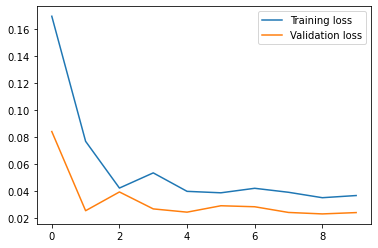

In [9]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [10]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
future = days_future + days_past

# days_past?
prediction_dates = pd.date_range(list(dates)[-future], periods=future, freq=us_bd).tolist()

prediction = model.predict(train_X[-future:])

1/1 [==============================] - 2s 2s/step


In [11]:
prediction_copies = np.repeat(prediction, df_train.shape[1], axis=-1)
y_forecast = scaler.inverse_transform(prediction_copies)[:,0]

In [12]:
forecast_dates = []
for time_i in prediction_dates:
    forecast_dates.append(time_i.date())

df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'open':y_forecast})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

In [13]:
original = df[['date', 'open']]
original['date']=pd.to_datetime(original['date'])
original = original.loc[original['date'] >= '2021-8-1']

/var/folders/5_/bb05t_s57j12tjmc9s6_yg_r0000gn/T/ipykernel_48761/740320029.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['date']=pd.to_datetime(original['date'])


/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='date', ylabel='open'>

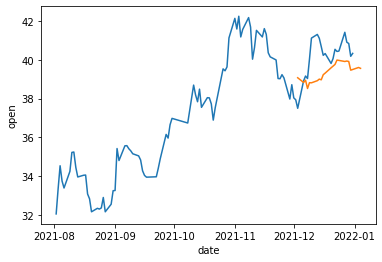

In [14]:
import seaborn as sns

sns.lineplot(original['date'], original['open'])
sns.lineplot(df_forecast['date'], df_forecast['open'])

In [281]:
result = pd.concat([df,df_forecast], axis=0, join="outer")
result.to_csv("600887_YLGF.csv")

In [15]:
df.to_csv("600887_YLGF.csv")